
=== TransNet Burgers baseline, M=300 ===
Searching gamma_opt ...
gamma_opt=9.375, total=2.903e-03, MSE_int=2.526e-03, MSE_ic=3.726e-05, MSE_bc=3.817e-05
[Burgers baseline + golden γ_opt] L2 error vs FD: 4.095e-01


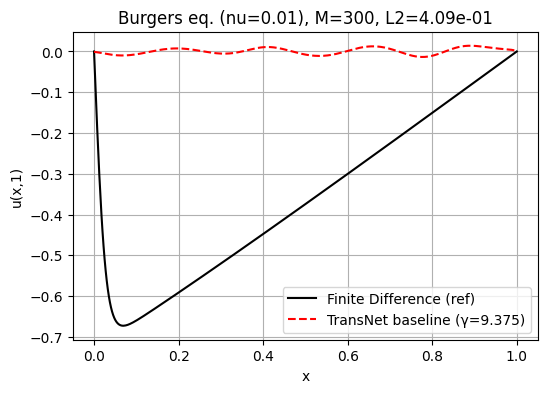

In [ ]:
import numpy as np
import math, time
import matplotlib.pyplot as plt

pi = math.pi
nu = 0.01
xc = np.array([0.5, 0.5])   # ✅ center shift

# ---------------- PDE setup: Burgers equation ----------------
def u_ic(x): return -np.sin(pi * x)
def f_np(X):  # forcing = 0
    return np.zeros(X.shape[0])

# ---------------- TransNet basis helpers ----------------
def sigma(s): return np.tanh(s)
def sigma_dd(s):
    t = np.tanh(s)
    sech2 = 1.0 - t*t
    return -2.0 * t * sech2

def sample_a_r(M, d=2, R=1.5, seed=1234):
    rng = np.random.RandomState(seed)
    A = rng.randn(M, d)
    A /= np.linalg.norm(A, axis=1, keepdims=True)
    r = rng.uniform(-R, R, size=M)
    return A, r

def build_blocks_burgers(X_int, X_ic, X_bc, A, r, gamma):
    # ✅ shift by xc
    X_int_c = X_int - xc
    X_ic_c  = X_ic  - xc
    X_bc_c  = X_bc  - xc

    S_int = gamma*(X_int_c @ A.T + r[None,:])
    S_ic  = gamma*(X_ic_c  @ A.T + r[None,:])
    S_bc  = gamma*(X_bc_c  @ A.T + r[None,:])

    Psi_int = sigma(S_int)
    Psi_ic  = sigma(S_ic)
    Psi_bc  = sigma(S_bc)
    return Psi_int, Psi_ic, Psi_bc

def solve_alpha_ls(Psi_int, Psi_ic, Psi_bc, rhs_int, rhs_ic, rhs_bc,
                   w_int=1.0, w_ic=5.0, w_bc=5.0, reg=1e-2):
    A_big = np.vstack([w_int*Psi_int, w_ic*Psi_ic, w_bc*Psi_bc])
    b_big = np.concatenate([w_int*rhs_int, w_ic*rhs_ic, w_bc*rhs_bc])
    AtA = A_big.T @ A_big + reg*np.eye(A_big.shape[1])
    Atb = A_big.T @ b_big
    alpha = np.linalg.solve(AtA, Atb)
    return alpha

def u_base_numpy(X, A, r, gamma, alpha):
    Xc = X - xc   # ✅ shift
    S = gamma*(Xc @ A.T + r[None,:])
    return sigma(S) @ alpha

# ---------------- Golden-section search ----------------
def eta_of_gamma(gamma, X_int, X_ic, X_bc, rhs_int, rhs_ic, rhs_bc, A, r):
    Psi_int, Psi_ic, Psi_bc = build_blocks_burgers(X_int, X_ic, X_bc, A, r, gamma)
    alpha = solve_alpha_ls(Psi_int, Psi_ic, Psi_bc, rhs_int, rhs_ic, rhs_bc)
    resid_int = Psi_int @ alpha - rhs_int
    resid_ic  = Psi_ic  @ alpha - rhs_ic
    resid_bc  = Psi_bc  @ alpha - rhs_bc
    mse_int = np.mean(resid_int**2)
    mse_ic  = np.mean(resid_ic**2)
    mse_bc  = np.mean(resid_bc**2)
    total = mse_int + 5*mse_ic + 5*mse_bc
    return total, mse_int, mse_ic, mse_bc, alpha

def golden_search(func, a, b, tol=1e-3, max_iters=50):
    phi = (1 + 5**0.5)/2
    invphi = 1/phi
    c = b - invphi*(b-a)
    d = a + invphi*(b-a)
    fc = func(c)
    fd = func(d)
    for _ in range(max_iters):
        if abs(b-a) < tol:
            break
        if fc[0] < fd[0]:
            b, d, fd = d, c, fc
            c = b - invphi*(b-a)
            fc = func(c)
        else:
            a, c, fc = c, d, fd
            d = a + invphi*(b-a)
            fd = func(d)
    return (c, fc) if fc[0] < fd[0] else (d, fd)

# ---------------- Sampling ----------------
def sample_points(n_x=60, n_t=60):
    xs = np.linspace(0,1,n_x)
    ts = np.linspace(0,1,n_t)
    X, T = np.meshgrid(xs, ts, indexing='xy')
    X_int = np.stack([X.ravel(), T.ravel()], axis=-1)
    mask = (X_int[:,1]>0) & (X_int[:,0]>0) & (X_int[:,0]<1)
    return X_int[mask]

def sample_ic(n_x=100):
    xs = np.linspace(0,1,n_x)
    return np.stack([xs, np.zeros_like(xs)], axis=-1)

def sample_bc(n_t=100):
    ts = np.linspace(0,1,n_t)
    X0 = np.stack([np.zeros_like(ts), ts], axis=-1)
    X1 = np.stack([np.ones_like(ts), ts], axis=-1)
    return np.vstack([X0,X1])

# ---------------- Finite Difference reference ----------------
def burgers_fd(n_x=201, n_t=2000, nu=0.01, T=1.0):
    x = np.linspace(0, 1, n_x)
    dx = x[1]-x[0]
    dt = T / n_t
    u = -np.sin(np.pi * x)
    for n in range(n_t):
        u_x = np.zeros_like(u)
        u_x[1:-1] = (u[2:] - u[:-2]) / (2*dx)
        u_xx = np.zeros_like(u)
        u_xx[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2]) / (dx**2)
        u_new = u + dt * ( -u * u_x + nu * u_xx )
        u_new[0] = u_new[-1] = 0.0
        u = u_new
    return x, u

# ---------------- Run TransNet baseline with golden search ----------------
def run_transnet_burgers(M=300):
    print(f"\n=== TransNet Burgers baseline, M={M} ===")
    X_int = sample_points()
    X_ic  = sample_ic()
    X_bc  = sample_bc()
    rhs_int = np.zeros(X_int.shape[0])
    rhs_ic  = u_ic(X_ic[:,0])
    rhs_bc  = np.zeros(X_bc.shape[0])

    A, r = sample_a_r(M, d=2, R=1.6, seed=123)
    func = lambda g: eta_of_gamma(g, X_int, X_ic, X_bc, rhs_int, rhs_ic, rhs_bc, A, r)

    print("Searching gamma_opt ...")
    gamma_opt, best = golden_search(func, 1e-2, 80.0)
    total, mse_int, mse_ic, mse_bc, alpha_opt = best
    print(f"gamma_opt={gamma_opt:.3f}, total={total:.3e}, MSE_int={mse_int:.3e}, MSE_ic={mse_ic:.3e}, MSE_bc={mse_bc:.3e}")

    return A, r, alpha_opt, gamma_opt

# ---------------- Compare with FD ----------------
M = 300
A, r, alpha_opt, gamma_opt = run_transnet_burgers(M)

x_fd, u_fd = burgers_fd(n_x=401, n_t=4000, nu=nu, T=1.0)
X_test = np.stack([x_fd, np.ones_like(x_fd)], axis=-1)
u_pred_trans = u_base_numpy(X_test, A, r, gamma_opt, alpha_opt)

L2_err = np.sqrt(np.mean((u_pred_trans - u_fd)**2))
print(f"[Burgers baseline + golden γ_opt] L2 error vs FD: {L2_err:.3e}")

plt.figure(figsize=(6,4))
plt.plot(x_fd, u_fd, 'k-', label='Finite Difference (ref)')
plt.plot(x_fd, u_pred_trans, 'r--', label=f'TransNet baseline (γ={gamma_opt:.3f})')
plt.xlabel('x'); plt.ylabel('u(x,1)')
plt.legend()
plt.title(f'Burgers eq. (nu={nu}), M={M}, L2={L2_err:.2e}')
plt.grid(True); plt.show()


[Baseline] M=300, gamma_opt=9.812, mse_int=2.135e-03, mse_ic=1.541e-05, mse_bc=1.227e-05

[Hybrid] Train residual v_theta ...
Epoch    0 | total=8.372e+00 | pde=8.366e+00 | ic=6.078e-05 | bc=5.577e-04
Epoch  500 | total=3.571e-01 | pde=3.220e-01 | ic=2.150e-03 | bc=1.361e-03
Epoch 1000 | total=2.012e-01 | pde=1.779e-01 | ic=1.679e-03 | bc=6.525e-04
Epoch 1500 | total=1.627e-01 | pde=1.420e-01 | ic=1.001e-03 | bc=1.070e-03
Epoch 2000 | total=1.464e-01 | pde=1.225e-01 | ic=1.082e-03 | bc=1.310e-03
Epoch 2500 | total=1.063e-01 | pde=9.859e-02 | ic=4.964e-04 | bc=2.727e-04
Epoch 3000 | total=9.673e-02 | pde=9.240e-02 | ic=2.726e-04 | bc=1.604e-04
Epoch 3500 | total=9.638e-02 | pde=9.106e-02 | ic=2.930e-04 | bc=2.391e-04

[Hybrid-TransNet] L2 error vs FD (t=1): nan


/var/folders/42/tjxv8ldx65x5b07fdgrxyw5w0000gn/T/ipykernel_16277/4191613225.py:173: RuntimeWarning: overflow encountered in multiply
  u_new = u + dt * (-u*u_x + nu*u_xx)
/var/folders/42/tjxv8ldx65x5b07fdgrxyw5w0000gn/T/ipykernel_16277/4191613225.py:171: RuntimeWarning: invalid value encountered in subtract
  u_x = np.zeros_like(u); u_x[1:-1] = (u[2:] - u[:-2])/(2*dx)
/var/folders/42/tjxv8ldx65x5b07fdgrxyw5w0000gn/T/ipykernel_16277/4191613225.py:172: RuntimeWarning: invalid value encountered in subtract
  u_xx = np.zeros_like(u); u_xx[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2])/(dx**2)
/var/folders/42/tjxv8ldx65x5b07fdgrxyw5w0000gn/T/ipykernel_16277/4191613225.py:172: RuntimeWarning: invalid value encountered in add
  u_xx = np.zeros_like(u); u_xx[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2])/(dx**2)
/var/folders/42/tjxv8ldx65x5b07fdgrxyw5w0000gn/T/ipykernel_16277/4191613225.py:172: RuntimeWarning: overflow encountered in divide
  u_xx = np.zeros_like(u); u_xx[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2])/(dx*

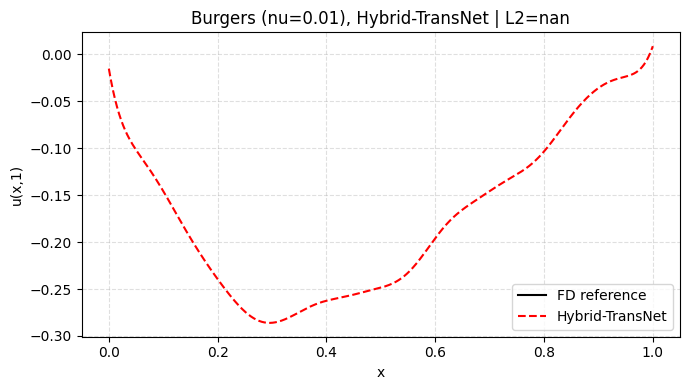

In [7]:
# ============================================================
# Burgers equation (1D space + 1D time) on [0,1]x[0,1]
# Hybrid-TransNet (Method 3):
#   1) Baseline TransNet via least squares + golden-search for gamma
#   2) Residual MLP v_theta trained on full nonlinear PDE residual
# ============================================================

import numpy as np
import math, time, json
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

# ----- precision & device -----
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pi = math.pi
nu = 0.01                    # viscosity
xc_np = np.array([0.5, 0.5]) # center shift
xc_t  = torch.tensor(xc_np, device=device)

# ---------------- IC/BC ----------------
def u_ic_np(x): return -np.sin(pi * x)
def u_ic_torch(x): return -torch.sin(pi * x)

# ---------------- sampling ----------------
def sample_interior(n_x=60, n_t=60):
    xs = np.linspace(0,1,n_x)
    ts = np.linspace(0,1,n_t)
    X, T = np.meshgrid(xs, ts, indexing='xy')
    P = np.stack([X.ravel(), T.ravel()], axis=-1)
    mask = (P[:,1]>0) & (P[:,0]>0) & (P[:,0]<1)
    return P[mask]

def sample_ic(n_x=160):
    xs = np.linspace(0,1,n_x)
    return np.stack([xs, np.zeros_like(xs)], axis=-1)

def sample_bc(n_t=160):
    ts = np.linspace(0,1,n_t)
    X0 = np.stack([np.zeros_like(ts), ts], axis=-1)
    X1 = np.stack([np.ones_like(ts),  ts], axis=-1)
    return X0, X1

# ---------------- TransNet helpers ----------------
def sigma(s): return np.tanh(s)
def sigma_dd(s):
    t = np.tanh(s); return -2.0*t*(1.0 - t*t)

def sample_a_r(M, d=2, R=0.75, seed=1234):
    rng = np.random.RandomState(seed)
    A = rng.randn(M, d)
    A /= np.linalg.norm(A, axis=1, keepdims=True)
    r = rng.uniform(-R, R, size=M)
    return A, r

def build_blocks_burgers(X_int, X_ic, X_bc, A, r, gamma):
    # center shift
    X_int_c = X_int - xc_np
    X_ic_c  = X_ic  - xc_np
    X_bc_c  = X_bc  - xc_np
    S_int = gamma*(X_int_c @ A.T + r[None,:])
    S_ic  = gamma*(X_ic_c  @ A.T + r[None,:])
    S_bc  = gamma*(X_bc_c  @ A.T + r[None,:])
    Psi_int = sigma(S_int)
    Psi_ic  = sigma(S_ic)
    Psi_bc  = sigma(S_bc)
    return Psi_int, Psi_ic, Psi_bc

def solve_alpha_ls(Psi_int, Psi_ic, Psi_bc, rhs_int, rhs_ic, rhs_bc,
                   w_int=1.0, w_ic=5.0, w_bc=5.0, reg=1e-2):
    A_big = np.vstack([w_int*Psi_int, w_ic*Psi_ic, w_bc*Psi_bc])
    b_big = np.concatenate([w_int*rhs_int, w_ic*rhs_ic, w_bc*rhs_bc])
    AtA = A_big.T @ A_big + reg*np.eye(A_big.shape[1])
    Atb = A_big.T @ b_big
    alpha = np.linalg.solve(AtA, Atb)
    return alpha

def u_base_numpy(X, A, r, gamma, alpha):
    Xc = X - xc_np
    S = gamma*(Xc @ A.T + r[None,:])
    return sigma(S) @ alpha

# ---------------- golden search for gamma ----------------
def eta_of_gamma(gamma, X_int, X_ic, X_bc, rhs_int, rhs_ic, rhs_bc, A, r):
    Psi_int, Psi_ic, Psi_bc = build_blocks_burgers(X_int, X_ic, X_bc, A, r, gamma)
    alpha = solve_alpha_ls(Psi_int, Psi_ic, Psi_bc, rhs_int, rhs_ic, rhs_bc)
    e_int = Psi_int @ alpha - rhs_int
    e_ic  = Psi_ic  @ alpha - rhs_ic
    e_bc  = Psi_bc  @ alpha - rhs_bc
    mse = np.mean(e_int**2) + 5.0*np.mean(e_ic**2) + 5.0*np.mean(e_bc**2)
    return (mse, e_int, e_ic, e_bc, alpha)

def golden_search(func, a, b, tol=1e-3, max_iters=50):
    phi = (1 + 5**0.5)/2; invphi = 1.0/phi
    c = b - invphi*(b-a); d = a + invphi*(b-a)
    fc = func(c); fd = func(d)
    for _ in range(max_iters):
        if abs(b-a) < tol: break
        if fc[0] < fd[0]:
            b, d, fd = d, c, fc
            c = b - invphi*(b-a); fc = func(c)
        else:
            a, c, fc = c, d, fd
            d = a + invphi*(b-a); fd = func(d)
    return (c, fc) if fc[0] < fd[0] else (d, fd)

# ---------------- baseline solve ----------------
def run_transnet_baseline(M=300, R=0.75, gamma_range=(1e-2, 80.0), seed=123):
    X_int = sample_interior(60,60)
    X_ic  = sample_ic(160)
    X_bc0, X_bc1 = sample_bc(160)
    X_bc = np.vstack([X_bc0, X_bc1])
    rhs_int = np.zeros(X_int.shape[0])
    rhs_ic  = u_ic_np(X_ic[:,0])
    rhs_bc  = np.zeros(X_bc.shape[0])

    A, r = sample_a_r(M, d=2, R=R, seed=seed)
    func = lambda g: eta_of_gamma(g, X_int, X_ic, X_bc, rhs_int, rhs_ic, rhs_bc, A, r)
    gamma_opt, best = golden_search(func, gamma_range[0], gamma_range[1])
    _, e_int, e_ic, e_bc, alpha_opt = best
    print(f"[Baseline] M={M}, gamma_opt={gamma_opt:.3f}, "
          f"mse_int={np.mean(e_int**2):.3e}, mse_ic={np.mean(e_ic**2):.3e}, mse_bc={np.mean(e_bc**2):.3e}")
    return (A, r, gamma_opt, alpha_opt), (X_int, X_ic, X_bc)

# ---------------- torch wrappers for u_base ----------------
def make_u_base_torch(A, r, gamma, alpha):
    A_t = torch.tensor(A, device=device)
    r_t = torch.tensor(r, device=device)
    alpha_t = torch.tensor(alpha, device=device)
    g_t = torch.tensor(gamma, device=device)

    def u_base_torch(x):  # x: (N,2)
        S = g_t * ((x - xc_t) @ A_t.t() + r_t)
        return torch.tanh(S) @ alpha_t
    return u_base_torch

# ---------------- autograd utilities ----------------
def grad_x(u, x):
    g = autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return g[:,0]
def grad_t(u, x):
    g = autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return g[:,1]
def grad_xx(u, x):
    ux = grad_x(u, x)
    g2 = autograd.grad(ux, x, grad_outputs=torch.ones_like(ux), create_graph=True)[0]
    return g2[:,0]

# ---------------- residual MLP (v_theta) ----------------
class MLP(nn.Module):
    def __init__(self, in_dim=2, hidden=64, depth=4):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden), nn.Tanh()]
        for _ in range(depth-1):
            layers += [nn.Linear(hidden, hidden), nn.Tanh()]
        layers += [nn.Linear(hidden, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x).squeeze(-1)

# ---------------- finite-difference reference (for eval) ----------------
def burgers_fd(n_x=401, n_t=4000, nu=0.01, T=1.0):
    x = np.linspace(0, 1, n_x)
    dx = x[1]-x[0]
    dt = T / n_t
    u = -np.sin(np.pi * x)
    for _ in range(n_t):
        u_x = np.zeros_like(u); u_x[1:-1] = (u[2:] - u[:-2])/(2*dx)
        u_xx = np.zeros_like(u); u_xx[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2])/(dx**2)
        u_new = u + dt * (-u*u_x + nu*u_xx)
        u_new[0] = u_new[-1] = 0.0
        u = u_new
    return x, u

# ---------------- main: baseline + residual training ----------------
if __name__ == "__main__":
    # 1) Baseline TransNet
    (A, r, gamma_opt, alpha_opt), (X_int_np, X_ic_np, X_bc_np) = run_transnet_baseline(M=300, R=0.75)

    # 2) Build torch tensors
    u_base_torch = make_u_base_torch(A, r, gamma_opt, alpha_opt)
    Xin  = torch.tensor(X_int_np, device=device)
    Xic  = torch.tensor(X_ic_np,  device=device)
    Xbc  = torch.tensor(X_bc_np,  device=device)
    u0_t = u_ic_torch(Xic[:,0])

    # 3) Residual MLP
    model = MLP(in_dim=2, hidden=64, depth=4).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    lam_ic, lam_bc = 10.0, 10.0
    epochs = 4000

    print("\n[Hybrid] Train residual v_theta ...")
    for ep in range(epochs):
        opt.zero_grad()
        # interior PDE residual with u = u_base + v
        x = Xin.clone().detach().requires_grad_(True)
        v = model(x)
        u = u_base_torch(x) + v
        ut  = grad_t(u, x)
        ux  = grad_x(u, x)
        uxx = grad_xx(u, x)
        r_pde = ut + u*ux - nu*uxx
        loss_pde = torch.mean(r_pde**2)

        # IC: u(x,0) = u_ic(x)
        u_ic_pred = u_base_torch(Xic) + model(Xic)
        loss_ic = torch.mean((u_ic_pred - u0_t)**2)

        # BC: u(0,t)=u(1,t)=0  (both ends included in Xbc)
        u_bc_pred = u_base_torch(Xbc) + model(Xbc)
        loss_bc = torch.mean(u_bc_pred**2)

        loss = loss_pde + lam_ic*loss_ic + lam_bc*loss_bc
        loss.backward(); opt.step()

        if ep % 500 == 0:
            print(f"Epoch {ep:4d} | total={loss.item():.3e} | pde={loss_pde.item():.3e} "
                  f"| ic={loss_ic.item():.3e} | bc={loss_bc.item():.3e}")

    # 4) Evaluate vs FD at t=1
    x_fd, u_fd = burgers_fd(n_x=801, n_t=6000, nu=nu, T=1.0)
    X_test = np.stack([x_fd, np.ones_like(x_fd)], axis=-1)
    Xt = torch.tensor(X_test, device=device)
    with torch.no_grad():
        u_pred = (u_base_torch(Xt) + model(Xt)).cpu().numpy()
    L2 = np.sqrt(np.mean((u_pred - u_fd)**2))
    print(f"\n[Hybrid-TransNet] L2 error vs FD (t=1): {L2:.3e}")

    # 5) Plot
    plt.figure(figsize=(7,4))
    plt.plot(x_fd, u_fd, 'k-', label='FD reference')
    plt.plot(x_fd, u_pred, 'r--', label='Hybrid-TransNet')
    plt.xlabel('x'); plt.ylabel('u(x,1)')
    plt.title(f'Burgers (nu={nu}), Hybrid-TransNet | L2={L2:.2e}')
    plt.grid(True, ls='--', alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()
